In [1]:
import numpy as np 
import pandas as pd 
import os

import torch
from torch.utils.data import SubsetRandomSampler, DataLoader

# get current notebook path
os.chdir( "/home/guido/github/spectralgradients/" )


from src.synt_data import SyntDataset
from src.train.model import TimeModule

from src.posthoc.egradients import ExpectedGradients
from src.posthoc.igradients import IntegratedGradients
from src.posthoc.saliency import Saliency, InputXGradient
from src.posthoc.tsgradients import TimeSpectralGradients as TSG

from src.metrics.lle import LocalLipschitzEstimate as LLE
from src.metrics.infidelity import Infidelity
from src.metrics.localization import Localization
from src.metrics.complexity import Complexity
from src.metrics.evaluate import Wrapper

torch.set_float32_matmul_precision('medium')
%pwd

'/home/guido/github/spectralgradients'

In [2]:
setup = 0
nperseg = 100
fs = 100
batch_size = 32
n_points_tsg = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = SyntDataset(setup = setup, nperseg=nperseg, return_mask=True)

data = SyntDataset(return_mask=True)
loader = DataLoader(
    data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(list(range(len(data) - data.n_samples))),
    num_workers=os.cpu_count(),
)

nn = TimeModule.load_from_checkpoint(
            f"output/model/setup{setup}/checkpoint.ckpt",
            input_shape=data[0][0].shape,
            fs=100,
            n_classes=data.n_class,
        ).nn.eval()

nn = Wrapper(
    nn,
    input_shape=data[0][0].shape,
)

baseline_size = 4 * batch_size
baseline = torch.randperm(len(data))[:baseline_size].long()
baseline, _, _ = data[baseline]


nyquist = fs / 2
f_res = fs / nperseg
freqs = torch.arange(0, nyquist + f_res, f_res)
n_points = len(freqs) * n_points_tsg



In [4]:
explainers = torch.nn.ModuleList(
[
    Saliency(f=nn),
    InputXGradient(f=nn),
    IntegratedGradients(
        f=nn, 
        baselines=torch.zeros(batch_size, *data[0][0].shape),
        n_points= n_points
    ),
    ExpectedGradients(
        f=nn, 
        baselines=baseline,
        n_points= n_points
    ),
    TSG( 
        f = nn, 
        fs = fs,
        nperseg = nperseg,
        n_points = n_points_tsg,
        strategy="highest" 
    ),
    TSG(     
        f = nn, 
        fs = fs,
        nperseg = nperseg,
        n_points = n_points_tsg,
        strategy="lowest" 
    ),
]
).to(device)

explainers_names = ["sal", "ixg", "ig", "eg", "tsgh", "tsgl"]

In [5]:
loc = Localization( f = nn )
inf = Infidelity( f = nn, percentage_res = .1 )
comp = Complexity()

for x, mask, target in loader:
    break

x_attr = []
loc_metric = []
comp_metric = []
inf_metric = []

for explainer in explainers:
    x_attr = x_attr + [ explainer( x.to(device)) ]
    loc_metric = loc_metric + [ loc( x.to(device), x_attr[-1].to(device), mask.to(device))]
    comp_metric = comp_metric + [ comp( x.to(device), x_attr[-1].to(device), mask.to(device))]
    inf_metric = inf_metric + [ inf( x.to(device), x_attr[-1].to(device), mask.to(device))]

x_attr = torch.stack( x_attr, dim = 0)
loc_metric = torch.stack( loc_metric, dim = 0)
comp_metric = torch.stack( comp_metric, dim = 0)
inf_metric = torch.stack( inf_metric, dim = 0)

print( x_attr.shape, loc_metric.shape, comp_metric.shape, inf_metric.shape )

torch.Size([6, 32, 5, 1000]) torch.Size([6, 32, 5]) torch.Size([6, 32, 5]) torch.Size([6, 32, 5])


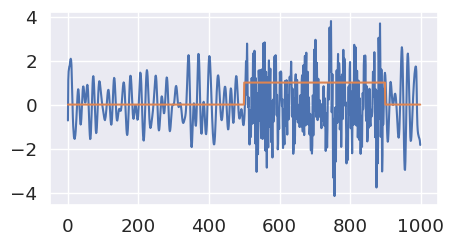

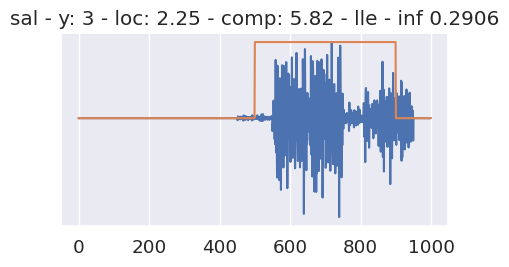

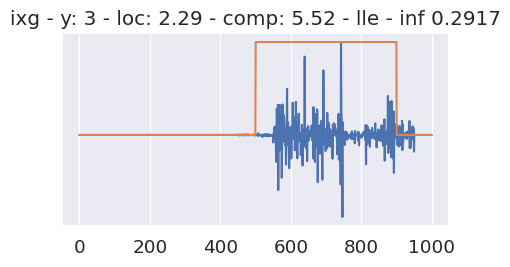

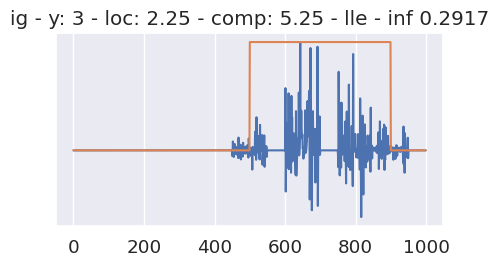

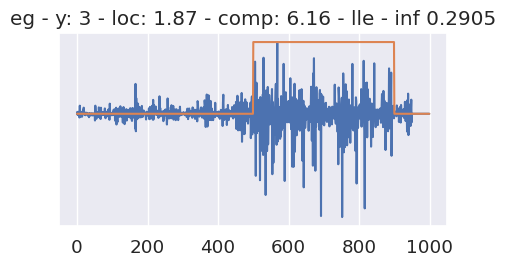

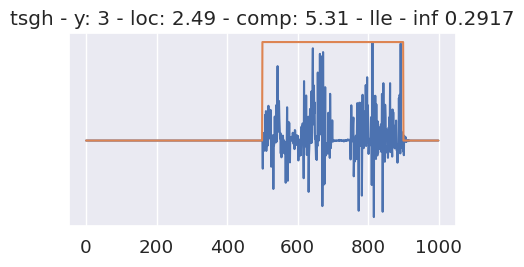

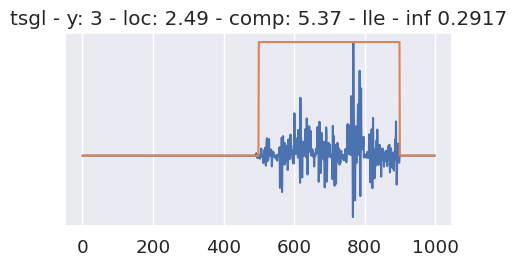

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(
    context='notebook', 
    style='darkgrid', 
    palette='deep', 
    font='sans-serif', 
    font_scale=1.2, 
    color_codes=True, 
    rc={'figure.figsize':(5, 2.5)}
)

sns.lineplot( x[0].numpy() )
sns.lineplot( mask[0].numpy())
plt.show()

for attr, lmetric, cmetric, imetric,  name in zip(x_attr, loc_metric, comp_metric, inf_metric, explainers_names):
    attr = attr[0, target[0]]
    #attr = torch.nn.functional.relu( attr )
    attr = attr.detach().cpu().numpy()
    sns.lineplot( attr )
    loc_val =  lmetric[0, target[0]]
    comp_val = cmetric[0, target[0]]
    inf_val = imetric[0, target[0]]
    #lle_val = llmetric[0, target[0]]

    plt.title( f"{name} - y: {target[0]} - loc: {loc_val:.2f} - comp: {comp_val:.2f} - lle - inf {inf_val:.4f}" )
    sns.lineplot( mask[0].numpy() * attr.max() )

    plt.yticks( ticks = [], labels = [])
    plt.show()
    
